In [1]:
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
#PYSPARK_DRIVER_PYTHON = 3.85
#PYSPARK_PYTHON = 3.85
import os
import sys
#import pyspark as spark

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Same code as shown in SimpleApp.py


In [2]:
def open_with_spark(log_file="data/movies.csv", app_name="movieAnalysis"):
    spark = SparkSession.builder.config("spark.executor.memory", "4g").config("spark.driver.memory", "2g").config("spark.storage.memoryFraction", "0.6").appName(app_name).getOrCreate()
    df = spark.read.option("header",True).csv(log_file).cache()
    return df

In [3]:
import pyspark
"""
1. Summary statistics for each relevant data frame

"""
def summary_statistics(df: pyspark.sql.dataframe.DataFrame, cols= ["*"], stats = ["count", "mean", "stddev", "min", "25%", "50%", "75%", "max"], name=None):
    summary = df.select(*cols).summary(*stats)
    summary.coalesce(1).write.csv(f'results/{name}_summary.csv')
    summary.show()
# 1. Do all
def summary_statistics_complete(file= "data/ratings.csv", cols= ["*"], stats = ["count", "mean", "stddev", "min", "25%", "50%", "75%", "max"], name=None):
    summary_statistics(open_with_spark(file), cols, stats, name=name)

"""

2. Join Dataframes READABLE version, more memory needed

"""
def join_ratings_and_movies_readable():  
    df_movie = open_with_spark()
    df_ratings = open_with_spark(log_file="data/ratings.csv", app_name="ratings")
    df_join = df_ratings.join(df_movie, "movieID")
    return df_join
    
# 2. Join Dataframes
def join_ratings_and_movies(): 
    return open_with_spark().join(open_with_spark(log_file="data/ratings.csv", app_name="ratings"), "movieID")

"""
3. Most-rated movies

Returns the top N movies with the most reviews (ratings)

"""
# 3. Most-rated movies
def most_rated(df: pyspark.sql.dataframe.DataFrame, N=10):
    return df.groupby("title").agg(F.count("rating")).withColumnRenamed("count(rating)", "Num_ratings").sort("Num_ratings", ascending=False).limit(N)

# 3. Function that does everything; can be used for timing or outputting or whatever
def most_rated_complete(N=10):
    JOINED = join_ratings_and_movies()
    TOP_N = most_rated(JOINED, N)
    return TOP_N

"""

4. Highest-average-rated movies

Returns the top N movies with the highest average reviews (ratings)

"""

# 4. Highest-average-rated movies
def best_average_rated(df: pyspark.sql.dataframe.DataFrame, N=10, MIN_RATINGS=50):
    T = df.groupby("title").agg(F.mean("rating"))
    H = T.withColumnRenamed("avg(rating)", "Mean_rating")
    # H.show(5)
    G = df.groupby("title").agg(F.count("rating")).withColumnRenamed("count(rating)", "Num_ratings")
    C = H.join(G, "title")
    C = C.filter(C.Num_ratings >= MIN_RATINGS).select(["title", "Mean_rating"])
    J = C.sort("Mean_rating", ascending=False)
    K = J.limit(N).withColumn("Mean_rating", F.round("Mean_rating",3))
    return K

# 4. Function that does everything; can be used for timing or outputting or whatever
def best_average_rated_complete(N=10, MIN_RATINGS=50):
    JOINED = join_ratings_and_movies()
    TOP_N = best_average_rated(JOINED, N, MIN_RATINGS)
    return TOP_N 

"""

5. Popular genres: 

Find the top N popular genres by calculating the average rating for each genre.

"""

def popular_genres(df: pyspark.sql.dataframe.DataFrame, N=5, MIN_RATINGS=10):
    L = df.groupby("genres").agg(F.mean("rating"))
    L.show(5)
    M = L.withColumnRenamed("avg(rating)", "Mean_rating")
    G = df.groupby("genres").agg(F.count("rating")).withColumnRenamed("count(rating)", "Num_ratings")
    M.show(5)
    K = M.join(G, "genres")
    P = K.filter(K.Num_ratings >= MIN_RATINGS).select(["genres", "Mean_rating"])
    N = P.sort("Mean_rating", ascending=False).limit(N).withColumn("Mean_rating", F.round("Mean_rating",3))
    return N
# 5. Retrives DF then computes Top N DF
def popular_genres_complete(N=5, MIN_RATINGS=10):
    JOINED = join_ratings_and_movies()
    TOP_N = popular_genres(JOINED, N)
    return TOP_N


In [ ]:
summary_statistics_complete("data/movies.csv",["title"], 'movies')

In [29]:
"""

Print out number of movies and number of unqiue users.

"""

summary_statistics_complete("data/movies.csv",["title"], ["count"], 'movies')
# Get df of unique users
df_unique_users = open_with_spark("data/ratings.csv").select("UserID").distinct()
summary_statistics(df_unique_users,["userID"], ["count"], 'unique_users')

23/04/18 19:23:42 WARN CacheManager: Asked to cache already cached data.
+-------+-----+
|summary|title|
+-------+-----+
|  count|58098|
+-------+-----+

23/04/18 19:23:42 WARN CacheManager: Asked to cache already cached data.


+-------+------+
|summary|userID|
+-------+------+
|  count|283228|
+-------+------+



In [30]:
summary_statistics_complete("data/ratings.csv",["rating"], name='rating_all').write.csv('results/summary')

23/04/18 19:25:29 WARN CacheManager: Asked to cache already cached data.


+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|          27753444|
|   mean|3.5304452124932677|
| stddev| 1.066352750231989|
|    min|               0.5|
|    25%|               3.0|
|    50%|               3.5|
|    75%|               4.0|
|    max|               5.0|
+-------+------------------+



AttributeError: 'NoneType' object has no attribute 'write'

In [4]:
import matplotlib.pyplot as plt
R = open_with_spark("data/ratings.csv").select("rating")
plt.hist(R.collect())
plt.show()

23/05/09 19:49:12 WARN Utils: Your hostname, Anthonys-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.67.104.250 instead (on interface en0)
23/05/09 19:49:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/09 19:49:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


23/05/09 19:49:26 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Py4JJavaError: An error occurred while calling o40.collectToPython.
: java.lang.OutOfMemoryError: Java heap space
	at scala.collection.mutable.ResizableArray.ensureSize(ResizableArray.scala:106)
	at scala.collection.mutable.ResizableArray.ensureSize$(ResizableArray.scala:96)
	at scala.collection.mutable.ArrayBuffer.ensureSize(ArrayBuffer.scala:49)
	at scala.collection.mutable.ArrayBuffer.$plus$eq(ArrayBuffer.scala:85)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$2(SparkPlan.scala:425)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$3222/0x0000000801e735e8.apply(Unknown Source)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.util.NextIterator.foreach(NextIterator.scala:21)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1(SparkPlan.scala:425)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1$adapted(SparkPlan.scala:424)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$3221/0x0000000801e73218.apply(Unknown Source)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:424)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3688)
	at org.apache.spark.sql.Dataset$$Lambda$2856/0x0000000801db0b58.apply(Unknown Source)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:3858)
	at org.apache.spark.sql.Dataset$$Lambda$2042/0x0000000801b84128.apply(Unknown Source)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:510)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3856)
	at org.apache.spark.sql.Dataset$$Lambda$1709/0x0000000801aacfa0.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1720/0x0000000801aafd20.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1710/0x0000000801aad260.apply(Unknown Source)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3856)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3685)


In [8]:
# 2. Join Dataframes READABLE version, more memory needed
def join_ratings_and_movies_readable():  
    df_movie = open_with_spark()
    df_ratings = open_with_spark(log_file="data/ratings.csv", app_name="ratings")
    df_join = df_ratings.join(df_movie, "movieID")
    return df_join
    
# 2. Join Dataframes
def join_ratings_and_movies(): 
    return open_with_spark().join(open_with_spark(log_file="data/ratings.csv", app_name="ratings"), "movieID")

In [4]:
X = join_ratings_and_movies()
X.show(5)

23/05/09 19:57:12 WARN Utils: Your hostname, Anthonys-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.67.104.250 instead (on interface en0)
23/05/09 19:57:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/09 19:57:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/09 19:57:18 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


23/05/09 19:57:26 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
+-------+--------------------+--------------+------+------+----------+
|movieId|               title|        genres|userId|rating| timestamp|
+-------+--------------------+--------------+------+------+----------+
|    307|Three Colors: Blu...|         Drama|     1|   3.5|1256677221|
|    481|   Kalifornia (1993)|Drama|Thriller|     1|   3.5|1256677456|
|   1091|Weekend at Bernie...|        Comedy|     1|   1.5|1256677471|
|   1257|Better Off Dead.....|Comedy|Romance|     1|   4.5|1256677460|
|   1449|Waiting for Guffm...|        Comedy|     1|   4.5|1256677264|
+-------+--------------------+--------------+------+------+----------+
only showing top 5 rows



In [6]:
df_updated = X.groupby("title").agg(F.count("rating")).withColumnRenamed("count(rating)", "Num_ratings").sort("Num_ratings", ascending=False)
df_updated.limit(5)


23/04/13 17:40:44 WARN MemoryStore: Not enough space to cache rdd_32_1 in memory! (computed 35.3 MiB so far)
23/04/13 17:40:44 WARN BlockManager: Persisting block rdd_32_1 to disk instead.
23/04/13 17:40:50 WARN MemoryStore: Not enough space to cache rdd_32_7 in memory! (computed 54.6 MiB so far)
23/04/13 17:40:50 WARN BlockManager: Persisting block rdd_32_7 to disk instead.
23/04/13 17:40:50 WARN MemoryStore: Not enough space to cache rdd_32_2 in memory! (computed 54.4 MiB so far)
23/04/13 17:40:50 WARN BlockManager: Persisting block rdd_32_2 to disk instead.
23/04/13 17:40:50 WARN MemoryStore: Not enough space to cache rdd_32_6 in memory! (computed 54.7 MiB so far)
23/04/13 17:40:50 WARN BlockManager: Persisting block rdd_32_6 to disk instead.
23/04/13 17:40:50 WARN MemoryStore: Not enough space to cache rdd_32_4 in memory! (computed 54.6 MiB so far)
23/04/13 17:40:50 WARN BlockManager: Persisting block rdd_32_4 to disk instead.
23/04/13 17:40:51 WARN MemoryStore: Not enough space to

Row(title='Shawshank Redemption, The (1994)', Num_ratings=97999)

In [10]:
"""
Returns the top N movies with the most reviews (ratings)

"""
# (may be necessary for @param type)
import pyspark

# 3. Most-rated movies
def most_rated(df: pyspark.sql.dataframe.DataFrame, N=10):
    if N == None:
        return df.groupby("title").agg(F.count("rating")).withColumnRenamed("count(rating)", "Num_ratings").sort("Num_ratings", ascending=False)
    else:
        return df.groupby("title").agg(F.count("rating")).withColumnRenamed("count(rating)", "Num_ratings").sort("Num_ratings", ascending=False).limit(N)

# Function that does everything; can be used for timing or outputting or whatever
def most_rated_complete(N=10):
    JOINED = join_ratings_and_movies()
    TOP_N = most_rated(JOINED, N)
    return TOP_N


In [7]:
most_rated(X, 5).show(5)

+--------------------+-----------+
|               title|Num_ratings|
+--------------------+-----------+
|Shawshank Redempt...|      97999|
| Forrest Gump (1994)|      97040|
| Pulp Fiction (1994)|      92406|
|Silence of the La...|      87899|
|  Matrix, The (1999)|      84545|
+--------------------+-----------+



In [8]:
X.columns

['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp']

In [31]:
most_rated_df = most_rated(X, 500)

In [34]:
most_rated_df.repartition(1).write.csv('results/500_most_rated.csv', header=True)

23/04/18 18:09:18 WARN MemoryStore: Not enough space to cache rdd_35_4 in memory! (computed 22.6 MiB so far)
23/04/18 18:09:18 WARN MemoryStore: Not enough space to cache rdd_35_3 in memory! (computed 22.6 MiB so far)
23/04/18 18:09:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/18 18:09:18 WARN MemoryStore: Not enough space to cache rdd_35_2 in memory! (computed 22.5 MiB so far)


In [4]:
"""
Returns the top N movies with the highest average reviews (ratings)

"""
# (may be necessary for @param type)
import pyspark

# 4. Highest-average-rated movies
def best_average_rated(df: pyspark.sql.dataframe.DataFrame, N=10, MIN_RATINGS=50):
    T = df.groupby("title").agg(F.mean("rating"))
    H = T.withColumnRenamed("avg(rating)", "Mean_rating")
    # H.show(5)
    G = df.groupby("title").agg(F.count("rating")).withColumnRenamed("count(rating)", "Num_ratings")
    C = H.join(G, "title")
    C = C.filter(C.Num_ratings >= MIN_RATINGS).select(["title", "Mean_rating"])
    J = C.sort("Mean_rating", ascending=False)
    K = J.limit(N).withColumn("Mean_rating", F.round("Mean_rating",3))
    return K

# Function that does everything; can be used for timing or outputting or whatever
def best_average_rated_complete(N=10, MIN_RATINGS=50):
    JOINED = join_ratings_and_movies()
    TOP_N = best_average_rated(JOINED, N, MIN_RATINGS)
    return TOP_N #.select("*", round("Mean_ratings"))

In [13]:
A = best_average_rated_complete(N = 500, MIN_RATINGS=100)
A.write.csv('results/500_average_rated.csv', header=True)

23/04/18 18:59:13 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
23/04/18 18:59:13 WARN CacheManager: Asked to cache already cached data.
23/04/18 18:59:13 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
23/04/18 18:59:13 WARN CacheManager: Asked to cache already cached data.


In [21]:
"""
5. Popular genres: Find the top N popular genres by calculating the average rating for each genre.
"""
import pyspark
def popular_genres(df: pyspark.sql.dataframe.DataFrame, N, MIN_RATINGS):
    L = df.groupby("genres").agg(F.mean("rating"))
    M = L.withColumnRenamed("avg(rating)", "Mean_rating")
    G = df.groupby("genres").agg(F.count("rating")).withColumnRenamed("count(rating)", "Num_ratings")
    K = M.join(G, "genres")
    P = K.filter(K.Num_ratings >= MIN_RATINGS).select(["genres", "Mean_rating"])
    N = P.sort("Mean_rating", ascending=False).limit(N).withColumn("Mean_rating", F.round("Mean_rating",3))
    return N
def popular_genres_complete(N=20, MIN_RATINGS=0):
    JOINED = join_ratings_and_movies()
    TOP_N = popular_genres(JOINED, N, MIN_RATINGS=MIN_RATINGS)
    return TOP_N

In [22]:
W = popular_genres_complete(N=20, MIN_RATINGS=0)
W.write.csv('results/20_average_rated_genres.csv', header=True)


23/04/18 19:11:33 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
23/04/18 19:11:33 WARN CacheManager: Asked to cache already cached data.
23/04/18 19:11:33 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
23/04/18 19:11:34 WARN CacheManager: Asked to cache already cached data.


AnalysisException: path file:/Users/anthonycampbell/Documents/GitHub/Movies-Analysis/results/20_average_rated_genres.csv already exists.

In [23]:
W.show()

+--------------------+-----------+
|              genres|Mean_rating|
+--------------------+-----------+
|Adventure|Drama|R...|        5.0|
|Action|Drama|Myst...|        5.0|
|Adventure|Childre...|        5.0|
|Comedy|Fantasy|Ro...|      4.625|
|Action|Drama|Fant...|        4.5|
|Action|Children|D...|        4.5|
|Action|Animation|...|       4.25|
|Action|Children|D...|       4.25|
|Action|Adventure|...|      4.201|
|Action|Adventure|...|      4.167|
|Film-Noir|Romance...|      4.164|
|Action|Crime|Dram...|      4.163|
|Action|Adventure|...|      4.157|
|Action|Crime|Dram...|      4.156|
|Adventure|Animati...|      4.152|
|Animation|Childre...|      4.145|
|   Film-Noir|Mystery|      4.128|
|Crime|Film-Noir|M...|      4.127|
|Action|Adventure|...|       4.12|
|Animation|Drama|F...|      4.118|
+--------------------+-----------+



In [5]:
"""
6. Year-wise analysis: 

Extract the release year from the movie title and analyze the number of movies released and their average ratings per year.

"""

# code needs some work filtering out bad years, works in general but some title must not end with the year in ( )
def year_analysis(df: pyspark.sql.dataframe.DataFrame, N=10):
    # add year column
    J = df.withColumn("year", F.col("title").substr(F.length("title")-4, F.length("title")).substr(1,4)).select("movieID", "year")
    K = J.join(open_with_spark("data/ratings.csv").select("movieID", "rating"), "movieID")
    #K.show(200)
    # get average rating per year
    #D = K.groupby("year").agg(F.mean("rating")).withColumnRenamed("avg(rating)", "Mean_rating").sort("Mean_rating", ascending = False)
    L = K.groupby("year").agg(F.count("rating")).withColumnRenamed("count(rating)", "Num_ratings").sort("Num_ratings", ascending=False)
    
    return  L #K.join(D, "year")
def year_analysis_complete(N=10):
    X = open_with_spark()
    Y = year_analysis(X, N)
    return Y

In [8]:
A = year_analysis_complete()
A = A.filter(A.Num_ratings > 1106)
A.show(1000)

23/04/27 14:33:14 WARN CacheManager: Asked to cache already cached data.
23/04/27 14:33:14 WARN CacheManager: Asked to cache already cached data.


+----+-----------+
|year|Num_ratings|
+----+-----------+
|1995|    1767979|
|1994|    1529657|
|1996|    1334834|
|1999|    1305889|
|2000|    1089609|
|1993|    1082362|
|1997|    1080028|
|1998|    1040732|
|2001|     983000|
|2002|     885726|
|2004|     849291|
|2003|     779270|
|2006|     617677|
|2007|     579220|
|2005|     570873|
|1992|     567142|
|1989|     558507|
|1990|     548939|
|2008|     547974|
|2009|     507131|
|1991|     486961|
|2010|     456500|
|1988|     428412|
|1987|     424588|
|1986|     422299|
|1984|     403551|
|2011|     372899|
|2012|     362019|
|2014|     356580|
|1985|     348500|
|2013|     336980|
|1982|     303667|
|2015|     278900|
|1980|     270448|
|1983|     245945|
|1981|     245589|
|1979|     220638|
|2016|     204613|
|1975|     182415|
|1977|     170660|
|1971|     153949|
|1978|     136967|
|1973|     132878|
|1974|     130366|
|1968|     125388|
|2017|     122004|
|1976|     121598|
|1972|     118265|
|1964|     108186|
|1967|      

In [32]:
"""
Outputs the users who rate the most

N is the number of top users to output

"""

def user_analysis_top_users(df: pyspark.sql.dataframe.DataFrame, N=10):
    Y = df.groupby("userID").agg(F.count("rating")).withColumnRenamed("count(rating)", "Num_ratings").sort("Num_ratings", ascending=False).limit(N)
    Z = df.groupby("userID").agg(F.mean("rating")).withColumnRenamed("avg(rating)", "Mean_ratings")
    return Y.join(Z,"userID")
def user_analysis_top_users_complete(N=10):
    X = open_with_spark(log_file="data/ratings.csv")
    Y = user_analysis_top_users(X, N)
    return Y

"""

Outputs the users who rate the HIGHEST (on average)

N is the number of top users to output
MIN is the minimum number of ratings to be considered (if not min all 5's)

ASCENDING is boolean to make function the LOWEST (on average) raters

"""   
def user_analysis_avg_raters(df: pyspark.sql.dataframe.DataFrame, N=10, MIN=100, ASCENDING=False):
    Y = df.groupby("userID").agg(F.mean("rating")).withColumnRenamed("avg(rating)", "Mean_ratings")
    Z = df.groupby("userID").agg(F.count("rating")).withColumnRenamed("count(rating)", "Num_ratings")
    Z = Z.filter(Z.Num_ratings >= MIN)
    
    return Y.join(Z,"userID").sort("Mean_ratings", ascending=ASCENDING).limit(N)

def user_analysis_avg_raters_complete(N=10, MIN=100, ASCENDING=False):
    X = open_with_spark(log_file="data/ratings.csv")
    Y = user_analysis_avg_raters(X, N, MIN, ASCENDING)
    return Y

In [33]:
D = user_analysis_avg_raters_complete(MIN=500)
D.show()

23/04/27 14:54:10 WARN CacheManager: Asked to cache already cached data.


+------+-----------------+-----------+
|userID|     Mean_ratings|Num_ratings|
+------+-----------------+-----------+
|165601|              5.0|        505|
|236710|              5.0|        518|
|234304|4.999380421313507|        807|
| 46846| 4.99009900990099|        505|
| 42161|            4.966|       1750|
|101046|4.893877551020408|        980|
|107894|4.836801040312094|        769|
|256715|4.836029411764706|        680|
|160393|4.824519230769231|        832|
| 81072|4.797959183673469|        735|
+------+-----------------+-----------+



In [5]:
import re
from pyspark.sql.types import IntegerType

def extract_year(title):
    year = re.search(r'\((\d{4})\)', title)
    if year:
        return int(year.group(1))
    else:
        return None

udf_extract_year = F.udf(extract_year, IntegerType())

def year_wise_analysis(df: pyspark.sql.dataframe.DataFrame):
    df = df.withColumn("year", udf_extract_year("title"))
    df_year_group = df.groupBy("year").agg(F.count("title").alias("num_movies"), F.mean("rating").alias("avg_rating")).sort("year")
    return df_year_group


In [15]:
year_group = year_wise_analysis(X)


In [16]:
year_group.show(5)


+----+----------+------------------+
|year|num_movies|        avg_rating|
+----+----------+------------------+
|null|      6863|3.6704793821943755|
|1874|        10|              2.55|
|1878|        14|2.9285714285714284|
|1883|         5|               2.3|
|1887|         9|1.7777777777777777|
+----+----------+------------------+
only showing top 5 rows



In [37]:
import matplotlib.pyplot as plt


def plot_year_wise_analysis(df_year_wise: pyspark.sql.dataframe.DataFrame):
    df_pandas = df_year_wise.toPandas()

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.bar(df_pandas['year'], df_pandas['num_movies'], alpha=0.5, color='b')
    ax2.plot(df_pandas['year'], df_pandas['avg_rating'], 'g-')

    ax1.set_xlabel("Year")
    ax1.set_ylabel("Number of Movies", color='b')
    ax2.set_ylabel("Average Rating", color='g')

    plt.show()


In [9]:
X.columns

['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp']

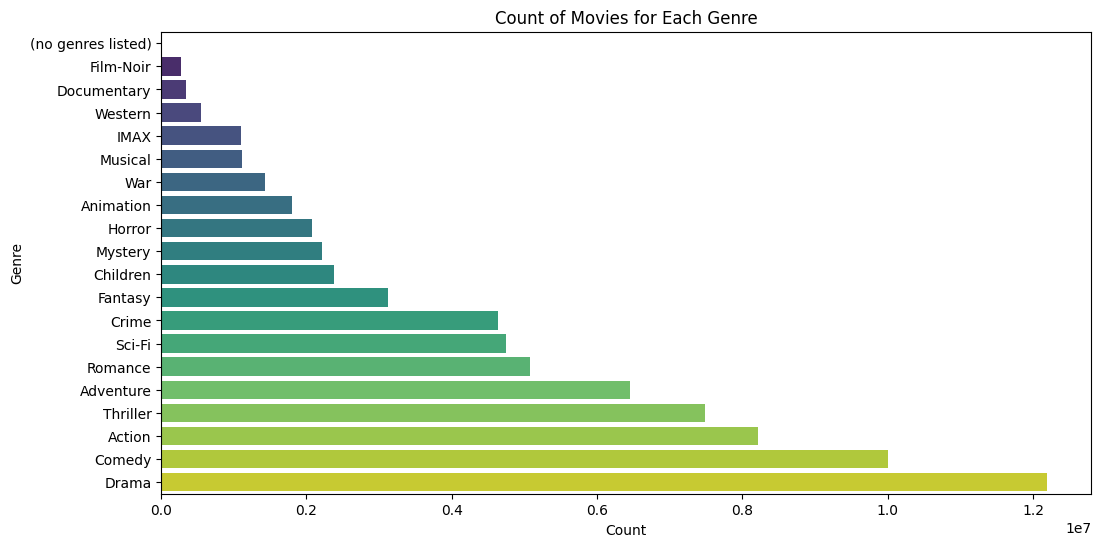

In [49]:
plot_genre_counts(X)


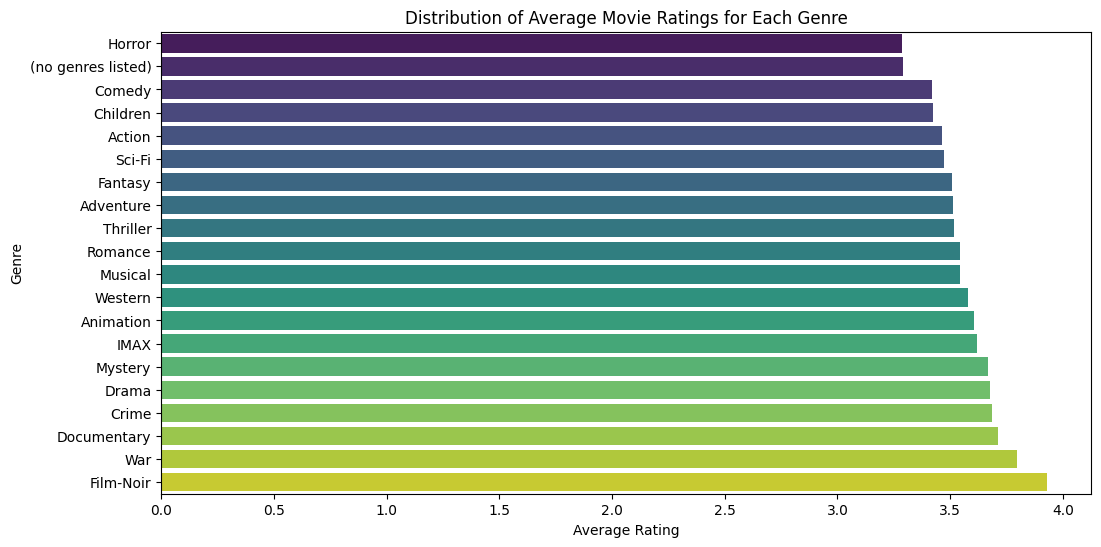

In [50]:
plot_genre_ratings(X)


In [6]:
box_plot_genre_ratings(X)


23/05/09 19:58:48 ERROR Executor: Exception in task 3.0 in stage 5.0 (TID 8)
java.lang.OutOfMemoryError: Java heap space
	at java.base/java.util.Arrays.copyOf(Arrays.java:3537)
	at java.base/java.io.ByteArrayOutputStream.ensureCapacity(ByteArrayOutputStream.java:100)
	at java.base/java.io.ByteArrayOutputStream.write(ByteArrayOutputStream.java:132)
	at org.apache.spark.util.ByteBufferOutputStream.write(ByteBufferOutputStream.scala:41)
	at java.base/java.io.ObjectOutputStream$BlockDataOutputStream.write(ObjectOutputStream.java:1871)
	at java.base/java.io.ObjectOutputStream.write(ObjectOutputStream.java:721)
	at org.apache.spark.util.Utils$.writeByteBuffer(Utils.scala:244)
	at org.apache.spark.scheduler.DirectTaskResult.$anonfun$writeExternal$1(TaskResult.scala:53)
	at org.apache.spark.scheduler.DirectTaskResult$$Lambda$2705/0x0000000801d6d830.apply$mcV$sp(Unknown Source)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.tryOrIOExc

23/05/09 19:58:48 ERROR Utils: Uncaught exception in thread Executor task launch worker for task 4.0 in stage 5.0 (TID 9)
java.lang.NullPointerException: Cannot invoke "org.apache.spark.SparkEnv.blockManager()" because the return value of "org.apache.spark.SparkEnv$.get()" is null
	at org.apache.spark.scheduler.Task.$anonfun$run$3(Task.scala:157)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1484)
	at org.apache.spark.scheduler.Task.run(Task.scala:155)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1623)


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/anthonycampbell/miniforge3/lib/python3.9/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Users/anthonycampbell/miniforge3/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
ConnectionResetError: [Errno 54] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/anthonycampbell/miniforge3/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/anthonycampbell/miniforge3/lib/python3.9/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):


ConnectionRefusedError: [Errno 61] Connection refused

In [7]:
plot_most_rated_movies(X)


ConnectionRefusedError: [Errno 61] Connection refused

In [8]:
plot_popular_genres(X)


ConnectionRefusedError: [Errno 61] Connection refused

In [ ]:
plot_popular_genres(X)
plot_movies_per_year(X)
plot_avg_ratings_per_year(X)
